In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv(r"C:\US-House-Analysis\notebook\data\US_House_Price.csv")

In [63]:
df.head()

,Date,State,Housing_Inventory,Construction_Costs,Land_Availability,Interest_Rates,Economic_Conditions,Population_Growth,Consumer_Confidence,Demographic_Trends,House_Price,House_Area_sqft,Location,Amenities
0,01-01-2010,Pennsylvania,60777,172403,Abundant,4.08,Moderate,1.59,High,Aging Population,183909,2286,Urban,Good Schools
1,02-01-2010,Kentucky,133587,121940,Limited,5.75,Weak,1.27,High,Aging Population,320286,2222,Urban,Good Schools
2,03-01-2010,South Dakota,114584,177811,Abundant,4.46,Weak,1.79,Moderate,Millennial Buyers,774649,1709,Suburban,Transport
3,04-01-2010,Texas,73366,192099,Limited,3.28,Weak,1.78,Moderate,Millennial Buyers,300061,1001,Suburban,Transport
4,05-01-2010,Tennessee,105705,161045,Abundant,4.62,Moderate,1.58,Moderate,Aging Population,268774,2666,Suburban,Transport


In [64]:
X = df.drop(columns=['Date','House_Price'],axis=1)
X.head()

,State,Housing_Inventory,Construction_Costs,Land_Availability,Interest_Rates,Economic_Conditions,Population_Growth,Consumer_Confidence,Demographic_Trends,House_Area_sqft,Location,Amenities
0,Pennsylvania,60777,172403,Abundant,4.08,Moderate,1.59,High,Aging Population,2286,Urban,Good Schools
1,Kentucky,133587,121940,Limited,5.75,Weak,1.27,High,Aging Population,2222,Urban,Good Schools
2,South Dakota,114584,177811,Abundant,4.46,Weak,1.79,Moderate,Millennial Buyers,1709,Suburban,Transport
3,Texas,73366,192099,Limited,3.28,Weak,1.78,Moderate,Millennial Buyers,1001,Suburban,Transport
4,Tennessee,105705,161045,Abundant,4.62,Moderate,1.58,Moderate,Aging Population,2666,Suburban,Transport


In [65]:
y = df['House_Price']
y.head()

0    183909
1    320286
2    774649
3    300061
4    268774
Name: House_Price, dtype: int64

In [66]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
            
# Define the custom ranking for each ordinal variable
State_categories = ['Pennsylvania', 'Kentucky', 'South Dakota', 'Texas', 'Tennessee',
                                'Illinois', 'Oregon', 'Wisconsin', 'Washington', 'Utah',
                                'Connecticut', 'Oklahoma', 'Maryland', 'Hawaii', 'West Virginia',
                                'Indiana', 'Maine', 'Rhode Island', 'Florida', 'Georgia',
                                'Alabama', 'Arkansas', 'Mississippi', 'New York', 'Iowa',
                                'Michigan', 'North Dakota', 'Alaska', 'Colorado', 'Virginia',
                                'Kansas', 'Ohio', 'Nebraska', 'South Carolina', 'New Hampshire',
                                'Wyoming', 'Louisiana', 'California', 'Nevada', 'Idaho',
                                'Missouri', 'Delaware', 'Massachusetts', 'New Jersey',
                                'New Mexico', 'North Carolina', 'Minnesota', 'Vermont', 'Montana',
                                'Arizona']
Land_Availability_categories = ['Abundant', 'Limited']
Economic_Conditions_categories = ['Moderate', 'Weak', 'Strong']
Consumer_Confidence_categories = ['High', 'Moderate', 'Low']
Demographic_Trends_categories = ['Aging Population', 'Millennial Buyers']
Location_categories = ['Urban', 'Suburban']
Amenities_categories = ['Good Schools', 'Transport']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[State_categories,
                                                              Land_Availability_categories,
                                                              Economic_Conditions_categories,
                                                              Consumer_Confidence_categories,
                                                              Demographic_Trends_categories,
                                                              Location_categories,
                                                              Amenities_categories])),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

In [67]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=33)

In [68]:
X.shape

(5000, 12)

In [69]:
xtrain = pd.DataFrame(preprocessor.fit_transform(xtrain),columns=preprocessor.get_feature_names_out())
xtest = pd.DataFrame(preprocessor.transform(xtest),columns=preprocessor.get_feature_names_out())

In [70]:
preprocessor.get_feature_names_out()


array(['num_pipeline__Housing_Inventory',
       'num_pipeline__Construction_Costs', 'num_pipeline__Interest_Rates',
       'num_pipeline__Population_Growth', 'num_pipeline__House_Area_sqft',
       'cat_pipeline__State', 'cat_pipeline__Land_Availability',
       'cat_pipeline__Economic_Conditions',
       'cat_pipeline__Consumer_Confidence',
       'cat_pipeline__Demographic_Trends', 'cat_pipeline__Location',
       'cat_pipeline__Amenities'], dtype=object)

In [71]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [52]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.2794
- Mean Absolute Error: 4.2114
- R2 Score: 0.8827
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.5635
- Mean Absolute Error: 4.4650
- R2 Score: 0.8384


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5511
- Mean Absolute Error: 5.1795
- R2 Score: 0.8194
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.2339
- Mean Absolute Error: 4.8635
- R2 Score: 0.7971


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.2768
- Mean Absolute Error: 4.2067
- R2 Score: 0.8828
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.5690
- Mean Absolute Error: 4.4765
- R2 Score: 0.8381


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7629
- Mean Absolute Error: 4.5608
- R2 Score: 0.8602
-----------------------

In [53]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
0,Linear Regression,0.838420
2,Ridge,0.838098
7,CatBoosting Regressor,0.812072
8,AdaBoost Regressor,0.799666
1,Lasso,0.797131
5,Random Forest Regressor,0.792960
3,K-Neighbors Regressor,0.773947
6,XGBRegressor,0.766563
4,Decision Tree,0.682213


Insights
- From the above all Regression algorithms Linear regression is the highest performance in R2 score

In [54]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9,10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.03, 'iterations': 500, 'depth': 5}
0.8683400631166778


In [55]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [56]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 4.4206
- Mean Absolute Error: 3.5118
- R2 Score: 0.9178
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.6013
- Mean Absolute Error: 4.5544
- R2 Score: 0.8362


In [57]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 13}
0.8082397271631783


In [58]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 6.2446
- Mean Absolute Error: 4.9592
- R2 Score: 0.8359
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.2662
- Mean Absolute Error: 4.8892
- R2 Score: 0.7950


In [59]:
# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 0.3}
0.8542717934551609


In [60]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 4.0163
- Mean Absolute Error: 3.2124
- R2 Score: 0.9321
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.0638
- Mean Absolute Error: 4.8785
- R2 Score: 0.8080


In [61]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 3.3246
- Mean Absolute Error: 2.6429
- R2 Score: 0.9535
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.7547
- Mean Absolute Error: 4.6393
- R2 Score: 0.8271


cat_pipeline__State                  81.243104
num_pipeline__House_Area_(sqft)       3.781784
num_pipeline__Population_Growth       3.313484
num_pipeline__Housing_Inventory       3.300847
num_pipeline__Interest_Rates          2.597196
num_pipeline__Construction_Costs      2.375676
cat_pipeline__Economic_Conditions     1.163519
cat_pipeline__Consumer_Confidence     0.970061
cat_pipeline__Demographic_Trends      0.545508
cat_pipeline__Location                0.271563
cat_pipeline__Amenities               0.256452
cat_pipeline__Land_Availability       0.180806
dtype: float64




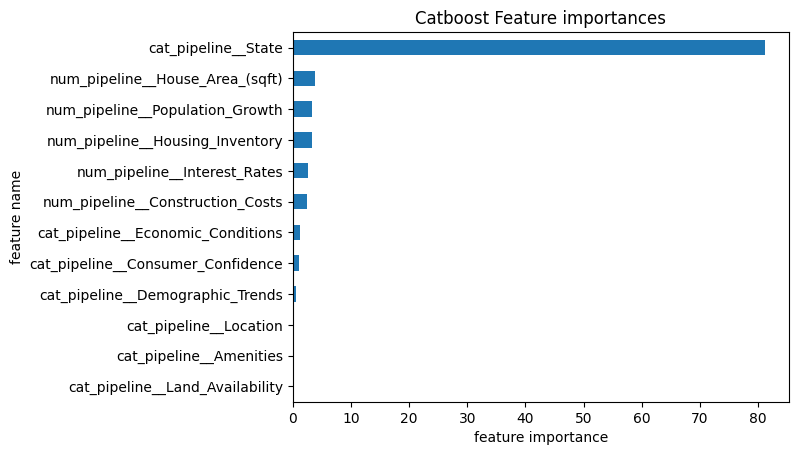

In [44]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()